## Feature Extraction (CNN) and similarity

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 

import os
import cv2
import pandas as pd
%matplotlib inline

In [2]:
#Load the coordinates data set
df = pd.read_csv('train.csv')

In [23]:
# Load images and resize 
root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img.shape[1]//3,img.shape[0]//3))
    train_crude.append(img)
    names.append(file.split('.')[0])
    
data = np.stack( train_crude, axis=0 )

In [24]:
train_crude[0].shape

(163, 226, 3)

In [25]:
data.shape

(7500, 163, 226, 3)

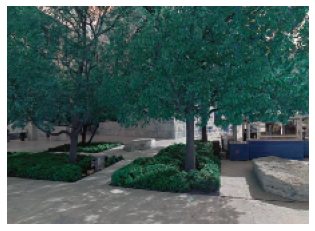

In [26]:
plt.imshow(data[0], cmap='gray')  
plt.title('')
plt.axis('off')
plt.show()

### Extract Features

#### CNN pre-trained

In [270]:
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', input_shape=[163, 226,3],include_top=False) 

In [34]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
base_model = ResNet50V2(weights='imagenet',input_shape=[163, 226,3],include_top=False)

In [20]:
#base_model.summary()

In [53]:
#get features in batches and flatten
feat = []
for i in range(0,7500,500):
    temp = base_model.predict(preprocess_input(data[i:i+500]))
    feat.append(temp)
    

feat0 = np.concatenate(feat, axis=0) 
feat2 = [i.ravel() for i in feat0]
feat2 = np.stack(feat2, axis=0)

In [54]:
feat2.shape

(7500, 98304)

##### Visualise Nearest neighbors

In [55]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(feat2)

NearestNeighbors(n_neighbors=6)

<AxesSubplot:xlabel='x', ylabel='y'>

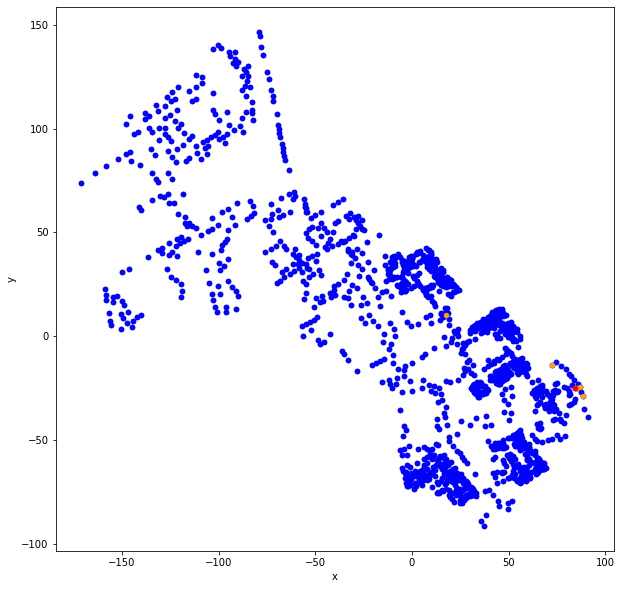

In [56]:
example = 500
nn = neigh.kneighbors(np.expand_dims(feat2[example], axis=0))
predictions = nn[1].tolist()[0]

original = df.iloc[example:example+1]
sample = df.iloc[predictions]
controls = df
ax = controls.plot(kind='scatter',x='x',y='y',figsize=(10,10), color='blue', alpha=0.5)
ax2 = sample.plot(ax=ax, kind='scatter',x='x',y='y',figsize=(10,10), color='orange')
original.plot(ax=ax2, kind='scatter',x='x',y='y',figsize=(10,10), color='red')


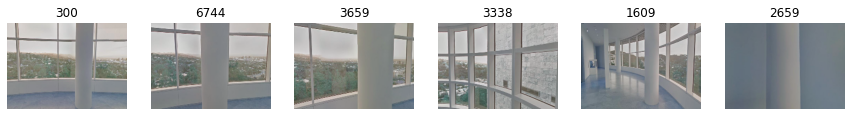

In [57]:
plt.subplots(figsize=(15,15))
for ix,im in enumerate(predictions):
    toShow = data[im]
    plt.subplot(1,6,ix+1)
    plt.imshow(toShow, cmap='gray')  
    plt.title(im)
    plt.axis('off')
plt.show()

##### Absolute Error Results (custom version)

In [58]:
# calculate absolute error
train = feat2[:7001]
test = feat2[7001:]

neighTest = NearestNeighbors(n_neighbors=5)
neighTest.fit(train)

predict = neighTest.kneighbors(test)

In [64]:
nn[0]

array([[5.3947965e-06, 3.6004791e+02, 4.0566992e+02, 4.3347540e+02,
        4.3572549e+02, 4.3671918e+02]], dtype=float32)

In [59]:
#Pseudo prediction by average closest neighbours
#It turns out it works as KNN regressor, but here I can set a similarity quality threshhold.
threshold_distance = 950
result = []
for ix, instance in enumerate(predict[1]):
    x = []
    y = []
    for n, i in enumerate(instance):
        #if no neighbour passes the thresthold, use just the most similar, which is always the first
        if n in [0] or predict[0][ix][n] < threshold_distance:    
            x.append(df.iloc[i].x)
            y.append(df.iloc[i].y)

    result.append([sum(x)/len(x),sum(y)/len(y)])
        

In [60]:
y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, result, multioutput='uniform_average')

34.21855711472828

##### SIFT

##### KNN regression version

In [297]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [3,5,7]}
knn = KNeighborsRegressor(n_jobs=-1)
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(feat2[:7001], df[['x','y']].iloc[:7001])

print(clf.best_score_)
clf.best_params_

-34.08494689289202


{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

In [61]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=3, metric = 'euclidean', weights='distance')
neighReg0.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictReg0 = neighReg0.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

32.0813379648212

##### Simple regression

In [65]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()
en.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictEN = en.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictEN, multioutput='uniform_average')

C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17434.93359375, tolerance: 2411.36669921875
  positive)
C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28758.6875, tolerance: 1836.829345703125
  positive)


26.803386073022153

In [68]:
"""
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(criterion = 'mae',max_depth =20, n_estimators = 10)
rfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictRFR = rfr.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
mean_absolute_error(y_true, predictRFR, multioutput='uniform_average')
"""

"\nfrom sklearn.ensemble import RandomForestRegressor\n\nrfr = RandomForestRegressor(criterion = 'mae',max_depth =20, n_estimators = 10)\nrfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])\npredictRFR = rfr.predict(feat2[7001:])\n\ny_true = df[['x','y']].iloc[7001:]\nmean_absolute_error(y_true, predictRFR, multioutput='uniform_average')\n"

In [309]:
from sklearn.linear_model import Ridge

rfr = Ridge()
rfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictRFR = rfr.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
mean_absolute_error(y_true, predictRFR, multioutput='uniform_average')

C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


48.708598873886075

##### full CNN

In [69]:
feat0.shape

(7500, 6, 8, 2048)

In [75]:
model3 = keras.Sequential(
    [
        layers.InputLayer((6, 8, 2048)),
        #layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        #layers.Dropout(0.25),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(2)
    ], 
)
opt = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
            loss=tf.keras.losses.MeanAbsoluteError(),
            metrics=['mae'])

In [76]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_27 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 16)               

In [100]:
cls4=model3.fit(feat0[:7001], df[['x','y']].iloc[:7001], validation_data=(feat0[7001:],df[['x','y']].iloc[7001:]),epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 3s 15ms/step - loss: 4.8679 - mae: 4.8679 - val_loss: 16.1132 - val_mae: 16.1132
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 4.6652 - mae: 4.6652 - val_loss: 14.7390 - val_mae: 14.7390
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 4.2844 - mae: 4.2844 - val_loss: 15.6081 - val_mae: 15.6081
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 4.0686 - mae: 4.0686 - val_loss: 15.4844 - val_mae: 15.4844
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 3.9056 - mae: 3.9056 - val_loss: 15.6980 - val_mae: 15.6980
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 3.8938 - mae: 3.8938 - val_loss: 14.5177 - val_mae: 14.5177
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 3.5730 - mae: 3.5730 - val_loss: 14.9644 - val_mae: 14.9644
Epoch 8/20
219/219 [==============================] - 3

In [101]:
model3.save('transCNN14')

INFO:tensorflow:Assets written to: transCNN14\assets


##### to test

In [87]:
oot= './test'
names_id = []
test_matrix = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (226, 163))
    test_matrix.append(img)
    names_id.append(file.split('.')[0])

test_data = np.stack( test_matrix, axis=0 )


In [88]:
data.shape

(7500, 163, 226, 3)

In [89]:
test_data.shape

(1200, 163, 226, 3)

In [103]:
feat_test = []
for i in range(0,test_data.shape[0],10):
    temp = base_model.predict(preprocess_input(test_data[i:i+10]))
    #print('round: '+i)
    feat_test.append(temp)

feat_test = np.concatenate(feat_test, axis=0)
feat_test.shape

(1200, 6, 8, 2048)

In [105]:
cnn_features_test = model3.predict(feat_test)

df_test = pd.read_csv('imagenames.csv')
df_test = pd.concat([df_test,pd.DataFrame(cnn_features_test, columns=['x','y'])], axis=1)
df_test.to_csv('CNNPredition', index=False)

#### AUTOENCODER

In [214]:
#reload data in a fitting size for the autoencoder to de code(no inexact divisions)
root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    train_crude.append(img)
    names.append(file.split('.')[0])

data = np.stack( train_crude, axis=0 )

In [215]:
data[0].shape

(280, 360)

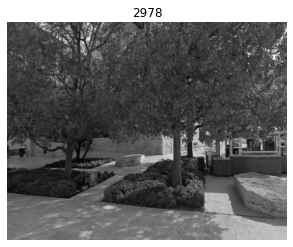

In [216]:
plt.imshow(data[0], cmap='gray')  
plt.title(im)
plt.axis('off')
plt.show()

In [217]:
input_img = keras.Input(shape=(280, 360,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [218]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 280, 360, 1)]     0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 280, 360, 16)      160       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 140, 180, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 140, 180, 8)       1160      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 70, 90, 8)         0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 70, 90, 8)         584       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 35, 45, 8)         0  

In [220]:

autoencoder.fit(data[:7000], data[:7000],
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(data[7000:], data[7000:]))

Epoch 1/50
110/110 [==============================] - 52s 402ms/step - loss: -1767.9202 - val_loss: -1808.7229
Epoch 2/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5150 - val_loss: -1808.7229
Epoch 3/50
110/110 [==============================] - 41s 377ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 4/50
110/110 [==============================] - 41s 373ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 5/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5153 - val_loss: -1808.7230
Epoch 6/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 7/50
110/110 [==============================] - 41s 370ms/step - loss: -1800.5151 - val_loss: -1808.7230
Epoch 8/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 9/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5149 - val_loss: -1808.7230
E

In [221]:
encoder = keras.Model(input_img, encoded)

In [235]:
encoder_features = encoder.predict(data)
encoder_features = [i.ravel() for i in encoder_features]
encoder_features = np.stack(encoder_features, axis=0)

In [237]:
encoder_features.shape

(7500, 12600)

In [239]:
from sklearn.neighbors import KNeighborsRegressor

neighReg = KNeighborsRegressor(n_neighbors=5)
neighReg.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

39.219920000567825

In [257]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [1,2,3,5,10],'n_jobs': [4]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])

print(clf.best_score_)
clf.best_params_

-37.03590577893906


{'metric': 'manhattan', 'n_jobs': 4, 'n_neighbors': 10, 'weights': 'distance'}

In [281]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.213217,0.017659,5.030996,0.423176,euclidean,4,1,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
1,0.197610,0.006348,4.564031,0.086157,euclidean,4,1,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
2,0.196416,0.004508,4.513096,0.104750,euclidean,4,2,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.756161,-42.823589,-44.274268,-44.944911,-43.063982,-43.572582,0.878847,20
3,0.213009,0.015812,4.950998,0.326221,euclidean,4,2,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.676606,-42.751364,-44.169609,-44.846863,-43.005243,-43.489937,0.865463,19
4,0.216995,0.008652,4.498116,0.112401,euclidean,4,3,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.223071,-41.077810,-42.929595,-43.135095,-41.449702,-41.963055,0.883475,14
5,0.208402,0.001356,4.487600,0.054375,euclidean,4,3,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.147340,-40.980152,-42.848500,-43.040543,-41.390511,-41.881409,0.879882,13
6,0.202649,0.003431,4.515605,0.056479,euclidean,4,5,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-40.012064,-39.956221,-41.518100,-41.402121,-39.687479,-40.515197,0.780149,12
7,0.206982,0.008607,4.505409,0.078060,euclidean,4,5,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-39.951656,-39.862734,-41.437735,-41.324903,-39.630182,-40.441442,0.775376,11
8,0.207402,0.004123,4.523387,0.036781,euclidean,4,10,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.863493,-38.884943,-40.334779,-40.269457,-38.898425,-39.450219,0.695968,8
9,0.208801,0.003249,4.551638,0.017008,euclidean,4,10,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.818635,-38.790535,-40.269245,-40.211524,-38.848654,-39.387719,0.696681,7


In [250]:
neighReg2 = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg2.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg2.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

36.357381006532634

##### To test

In [80]:
#load test data
root= './test'
names_id = []
test_matrix = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    test_matrix.append(img)
    names_id.append(file.split('.')[0])

test_data = np.stack( test_matrix, axis=0 )


In [245]:
encoder_features_test = base_model.predict(test_data)
encoder_features_test = [i.ravel() for i in encoder_features_test]
encoder_features_test = np.stack(encoder_features_test, axis=0)

In [247]:
neighReg = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg.fit(encoder_features, df[['x','y']])


KNeighborsRegressor(metric='manhattan', weights='distance')

In [248]:
test_predict = neighReg.predict(encoder_features_test)


In [249]:
test_predict

array([[ 37.68485471, -34.72265119],
       [ 13.60803497,   0.14159319],
       [ 23.25119436, -33.94169914],
       ...,
       [-29.15136877,  24.36858111],
       [ 27.08772355, -73.94742896],
       [ 17.49124652,   2.84351708]])

In [258]:
df_test = pd.read_csv('imagenames.csv')
df_test = pd.concat([df_test,pd.DataFrame(test_predict, columns=['x','y'])], axis=1)
df_test.to_csv('simplePredition', index=False)

## Baseline score

In [290]:
baseline = np.array([[df.x.mean(), df.y.mean()]*499]).reshape(499,2)
mean_absolute_error(y_true, baseline, multioutput='uniform_average')

44.90939559213609